In [22]:
%matplotlib inline
import os
import sys
import string
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from qm import*
from math import*
from random import shuffle
import random
import csv

plt.rcParams['figure.figsize'] = (15,5)

qm = QuineMcCluskey()

In [23]:
#Lê o arquivo de extensao .kiss e separa as listas com as informações sobre a msf

temp = open('beecount.kiss2')
line_char = temp.readlines()
l = []
entrada = []
lista_entradas = []
saida = []
lista_saidas = []

estados = []
estados = line_char[4:5]

atual = []
atual_inteiro = []
atual_convertido = []

proximo = []
proximo_inteiro = []
proximo_convertido = []

espaco_busca = []
espaco_aleatorio = []
estados_convertido = int(estados[0].split()[1])

#define o tamanho do espaço de busca basedado no valor entregue pelo arquivo

tamanho_espaco_busca = math.ceil(np.log2(estados_convertido))


msf_pronta = []

l = line_char[5:]

# nesse trecho os dados são separados, tratados e é criada a lista no formato que o Quine_Mccluskey pode simplificar

for i in range(len(l)):
    entrada = l[i].split()[0]
    lista_entradas.append(entrada)
    
    atual = l[i].split()[1]
    proximo = l[i].split()[2]
    saida = l[i].split()[3]
    lista_saidas.append(saida)
    
    atual_inteiro = int(atual[2:])
    proximo_inteiro = int(proximo[2:])
    atual_convertido.append(bin(atual_inteiro)[2:].zfill(tamanho_espaco_busca))
    #atual_binario = atual_convertido[i]
    proximo_convertido.append(bin(proximo_inteiro)[2:].zfill(tamanho_espaco_busca))
    #proximo_binario = proximo_convertido[i]
    linha = str(lista_entradas[i])+str(atual_convertido[i])+str(proximo_convertido[i])+str(lista_saidas[i])
    msf_pronta.append(linha)
    #print(msf_pronta[i])


#essa função calcula a quantidade de implicantes e variáveis de uma lista
    
def calculo_peso(lista_1):
    contador_dc = 0
    contador_termo = 0
    contador_literal = 0
    #tamanho_calculo = len(tamanho_espaco_busca)+len(saida)
    #para_calculo = lista_l[:tamanho_calculo]
    for i in range(len(lista_1)):
        contador_termo += 1
        for j in range(len(lista_1[i])):
            contador_literal +=1
            if (lista_1[i][j] == '-'):
                contador_dc += 1
    return (contador_termo+contador_literal)-contador_dc

# essa função separa da MSF as linhas relativas ao proximo estado e sáida para a contagem do peso

def prepara_lista(lista):
    para_calculo = []
    #print(len(entrada),len(atual_convertido[1]),len(proximo_convertido[1]),len(saida), len(lista[1]))
    for i in range(len(lista)):
        para_calculo.append(lista[i][len(entrada):-(len(saida))])
    return calculo_peso(para_calculo)
    

# neste ponto é criado o espaco de busca com todos as atribuicoes possíveis para representar a msf

for i in range (2**tamanho_espaco_busca):
        espaco_busca.append(bin(i)[2:].zfill(tamanho_espaco_busca))
        #espaco_aleatorio.append(bin(i)[2:].zfill(tamanho_espaco_busca))

# cria uma lista aleatória com os valores do espaço de busca

def cria_nova_msf():
    #print(tamanho_espaco_busca)
    espaco_aleatorio = espaco_busca.copy()
    shuffle(espaco_aleatorio)
    return set(espaco_aleatorio)


# faz a comparação entre a lista entregue e o valor correspondente a ela na lista de valores aleatórios

def correspondente(palavra1,palavra2):
    #espaco_aleatorio = list(cria_nova_msf())
    espaco_aleatorio = palavra2
    for i in range(len(espaco_busca)):
        if palavra1 == espaco_busca[i]:
            return str(espaco_aleatorio[i])

# recebe uma tabela, e a partir de comarações cria outra com os valores trocados pela atribuição aleatória

def nova_maquina():
    novo_atual = []
    novo_proximo = []
    nova_msf = []
    
    #esse trecho faz 5 embaralhamentos da lista para gerar valores aleatorio a cara criacao de uma conjunto de atribuicoes
    
    espaco_aleatorio = espaco_busca.copy()
    for i in range(3):
        shuffle(espaco_aleatorio)
    
    # percebi que esse trecho estava gerando uma nova lista de atribuicoes a cada chamada de teste de correspondencia
    # creio que isso estava causando um efeito indesejado, uma que vez isso provavelmente estava gerando inconsistencias 
    # que podem estar passando batidas
    # então agora é criada apenas uma lista que é utilizada para a comparacao entre atual e proximos estados da primeira 
    # lista e do novo conjunto de atribuicoes
    
    # aparentemente essa alteração, que pra mim faz sentido, fez cair muito a quantidade de geracao de msf's de tamanho menor que
    # a inicial
    
    for i in range(len(l)):
        #print(atual_convertido[i],proximo_convertido[i])
        novo_atual.append(correspondente(atual_convertido[i],espaco_aleatorio))
        #print("novo atual:",novo_atual[i])
        novo_proximo.append(correspondente(proximo_convertido[i],espaco_aleatorio))
        #print("novo proximo:",novo_proximo[i])
        nova_atrib = str(lista_entradas[i])+str(novo_atual[i])+str(novo_proximo[i])+str(lista_saidas[i])
        nova_msf.append(nova_atrib)
        
    return nova_msf

def simplifica(lista):
    lista_para_simplificar = []
    for i in range(len(lista)):
        lista_para_simplificar.append(lista[i][:-len(saida)])

    lista_simplificada = list(qm.simplify_los(lista_para_simplificar))
    return lista_simplificada

def calcula_custo(lista):
    #nova_lista = []
    nova_lista_prox = []
    nova_lista_transicoes = []
    lista_para_calculo = []
    comp_transit = len(entrada)+len(atual_convertido[0])
    comp_seg_lista = len(saida)+tamanho_espaco_busca
    for i in range(len(lista)):
        #nova_lista.append(lista[i][:-len(saida)])
        nova_lista_prox.append(lista[i][comp_transit:])
        nova_lista_transicoes.append(lista[i][:-tamanho_espaco_busca])
        
    for i in range(len(nova_lista_prox)):
        for j in range(len(nova_lista_prox[i])):
            if nova_lista_prox[i][j] == '1':
                #print(nova_lista_saidas[i])
                lista_para_calculo.append(nova_lista_transicoes[i])
    
    quantidade_dc = 0
    for i in range(len(lista_para_calculo)):
        for j in range(len(lista_para_calculo[i])):
            if lista_para_calculo[i][j] == '-':
                quantidade_dc += 1
                
    custo = (len(lista_para_calculo)*len(lista_para_calculo[0]))-quantidade_dc
    return custo
    #return nova_lista, nova_lista_transicoes, nova_lista_saidas,lista_para_calculo, custo
    
    
teste_nova_lista = nova_maquina()
#teste = cria_nova_msf()
#print(teste)
#print(espaco_busca)    
#teste = simplifica(msf_pronta)
#teste1 = list(qm.simplify_los(teste_nova_lista))
#for i in range(len(msf_pronta)):
#    print(msf_pronta[i],len(msf_pronta[i]),"-->",teste_nova_lista[i],len(teste_nova_lista[i]))

teste1 = list(simplifica(teste_nova_lista))
teste2 = list(simplifica(msf_pronta))

print(calcula_custo(teste2),calcula_custo(teste1))


for i in range(len(teste2)):
    print(teste2[i],len(teste2[i]),"-->",teste1[i],len(teste1[i]))



84 102
000000000 9 --> -00011010 9
000011000 9 --> 01001-011 9
1101-0101 9 --> 11011-111 9
--10--000 9 --> 11000-000 9
01010-100 9 --> 000001010 9
10000-001 9 --> --1-1-010 9
1000-0001 9 --> 110-11111 9
-00100000 9 --> 0-0100010 9
100110110 9 --> --1--0010 9
01001-011 9 --> --10--010 9
--1-0-000 9 --> 1000-0100 9
0-0001000 9 --> 01000-001 9
11010-101 9 --> 010-11011 9
1100-1010 9 --> 100-00100 9
100101110 9 --> 10011-110 9
000110000 9 --> 000-10010 9
11001-010 9 --> 110-00000 9


IndexError: list index out of range

In [27]:
def simulated_annealing(temperatura):
    temperatura_inicial = temperatura
    temperatura_final = 10
    menor_solucao = [] 
    melhor = list(simplifica(msf_pronta))
    menor_solucao = melhor
    custo_inicial = calcula_custo(melhor)
    menor_custo = custo_inicial
    print(custo_inicial)
    historico = [calcula_custo(melhor)]
    while temperatura > temperatura_final:
        for i in range(2):
            nova_solucao = nova_maquina()
            #np.warnings.filterwarnings('ignore')
            nova_solucao_simplificada = list(simplifica(nova_solucao))
            custo_local = calcula_custo(nova_solucao_simplificada)
            melhor_custo = calcula_custo(melhor)
            probabilidade = np.random.sample() # define um sample aleatorio entre 0 e 1, com zero fazendo parte do intervalo
            if (custo_local - melhor_custo <= 0) or (probabilidade < np.exp(-(custo_local-melhor_custo)/temperatura)):
            	melhor = nova_solucao_simplificada
            	historico.append(melhor_custo)
            	#print(temperatura,"trocou!!!!",)
            if custo_local <= menor_custo:
                menor_solucao = nova_solucao_simplificada
                menor_custo = custo_local
                print(menor_custo)
            
                    
        if temperatura > temperatura_inicial/2:
        	temperatura = 0.9*temperatura
        else:
        	temperatura = 0.5*temperatura
        #print(temperatura)
    #print("menor custo:",menor_custo)
    #custo_final = calcula_custo(melhor)
    #melhora = 100-((menor_custo *100)/custo_inicial)
    
    return melhor,menor_solucao, historico


84
0000-1101
100110001
010100011
100-00000
10010-000
--10--101
010011011
--1-0-101
110011100
110-10110
000-01101
-00010101
010101010
--1--0101
110001110
110-00100
100001001
010-10010
0-0000101
menor lista:
000000000
000011000
1101-0101
--10--000
01010-100
10000-001
1000-0001
-00100000
100110110
01001-011
--1-0-000
0-0001000
11010-101
1100-1010
100101110
000110000
11001-010
010-00100
--1--0000
84
[84, 84, 104, 145, 172, 141, 136, 128, 174, 103, 106, 185, 140, 132, 137, 122, 174, 155, 170, 179, 150, 112, 143, 150, 147]


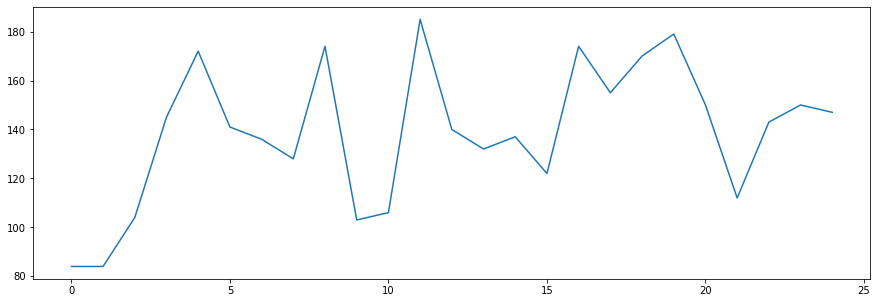

In [28]:
temperatura = 1000
resultado,menor_lista, historico = simulated_annealing(temperatura)
for i in range(len(resultado)):
	print(resultado[i])
print("menor lista:")
for i in range(len(menor_lista)):
	print(menor_lista[i])
print(calcula_custo(menor_lista))
print(historico)
plt.plot(historico)
#plt.plot(historico, hv(historico))


84


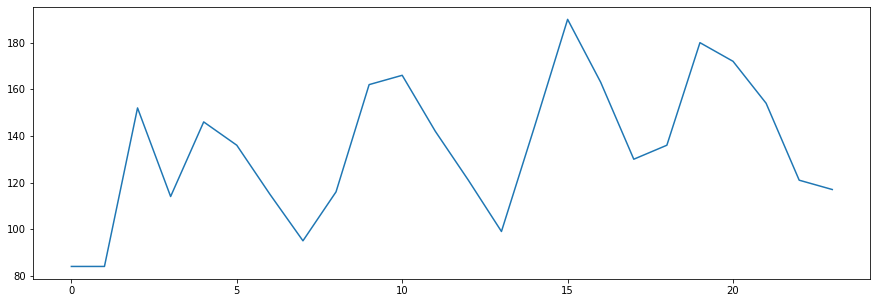

In [39]:
historico_total = []
for i in range(1):
    resultado,menor_lista, historico = simulated_annealing(temperatura)
    #print("menor lista:")
    #for s in range(len(menor_lista)):
    #    print(menor_lista[s])
    for k in range(len(historico)):
        historico_total.append(historico[k])
        
with open('valores.csv', mode='w', newline='') as resultados:
    writer = csv.writer(resultados)
    for j in range(len(historico_total)):
        writer.writerow([historico_total[j]])

plt.plot(historico_total)